# Initial EDA and Data Loading

This notebook contains the first steps of exploratory data analysis (EDA) for the 'Analytics Test & Data Set - Instructions' workbook.
We will: 
- Import necessary libraries.
- Locate and load the two sheets: 'RFI Data' (DCM) and 'Raw GA Data' (Google Analytics).
- Run quick EDA (info, describe, missing values, duplicates, sample rows).
- Convert date columns to datetime.

Assumptions: the sheet names are 'RFI Data' and 'Raw GA Data' and the Excel file is located in the notebook working directory. If the file is elsewhere, update the path in the file-detection cell.

In [1]:
# Cell 1: Imports and basic environment checks
import sys
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:

rfi_df = pd.read_excel("Analytics Test & Data Set - Instructions.xlsx", sheet_name='RFI Data')
ga_df = pd.read_excel("Analytics Test & Data Set - Instructions.xlsx", sheet_name='Raw GA Data', skiprows=3)

print("RFI shape:", rfi_df.shape)
print("GA shape:", ga_df.shape)


RFI shape: (4244, 9)
GA shape: (2403, 10)


## 🧩 Dataset 1 — Campaign Performance (DCM Data)

### **Overview**
This dataset contains media performance data extracted from **DoubleClick Campaign Manager (DCM)** or a similar ad-serving platform.  
It represents the **delivery and engagement metrics** of a digital marketing campaign across different websites, ad formats, and creative versions.

### **Data Dictionary**

| Column | Description |
|---------|-------------|
| **Campaign** | The official name of the marketing campaign, typically including brand, region, and fiscal year identifiers. |
| **Month** | The month when the campaign was active, formatted as `YYYY-MM`. |
| **Site (Site Directory)** | The publisher or website where the ad was served. |
| **Placement - DCM** | The type of placement or sponsorship configuration within DCM (e.g., “Condition Center Sponsorship”). |
| **Creative** | The unique identifier or name of the ad creative used in the campaign. Each creative may have multiple versions or dimensions. |
| **Creative Dimensions** | The pixel dimensions of the ad unit, such as `160x600`, `300x250`, or `728x90`. |
| **Platform Type** | The type of device or platform where the ad was served (e.g., *Desktop*, *Mobile Web*, *App*). This field may be empty if not specified. |
| **Impressions** | The total number of times the ad was displayed to users. |
| **Clicks** | The total number of clicks generated by the ad. |

### **Purpose**
This dataset is primarily used to analyze:
- Ad performance by **site**, **creative**, or **ad size**.  
- **Click-Through Rate (CTR)**: `(Clicks / Impressions) * 100`.  
- The effectiveness of different placements and formats in generating engagement.


## 📊 Dataset 2 — Web Analytics (GA4 Data)

### **Overview**
This dataset contains website performance data collected through **Google Analytics 4 (GA4)**.  
It provides insights into **user behavior** and **engagement** on the landing pages after users interact with the campaign ads.

### **Data Dictionary**

| Column | Description |
|---------|-------------|
| **Source** | The traffic source or media partner responsible for the user sessions (e.g., Acuity, Aptus). |
| **Month of Year** | The period of data collection, formatted as `YYYYMM`. |
| **Device Category** | The device type from which users accessed the website (*desktop*, *mobile*, *tablet*). |
| **Ad Content** | The UTM content parameter identifying the ad creative, version, and size (e.g., `AcuityCrossixTargeting.SD_1624_v3_Symptom.728`). |
| **Sessions** | The total number of sessions generated by users from the specific ad or source. |
| **Users** | The number of unique users who initiated at least one session. |
| **New Users** | The number of users who visited the website for the first time during that period. |
| **Pageviews** | The total number of pages viewed during the sessions. |
| **Session Duration** | The total duration of all sessions, usually measured in seconds. |
| **Calculated AToS (Average Time on Session)** | The average session duration, typically derived from `Session Duration / Sessions`. |

### **Purpose**
This dataset is used to measure:
- The **quality of traffic** driven by each campaign source or creative.  
- Engagement metrics such as **Average Session Duration**, **Pages per Session**, and **New User Ratio**.  
- The effectiveness of ad creatives and platforms in driving meaningful website interactions.


In [16]:
# ...existing code...
import re
from difflib import SequenceMatcher
import pandas as pd
pd.set_option('display.max_columns', None)

def safe_str(x):
    return '' if pd.isna(x) else str(x)

def extract_ga_parts(ad_content):
    s = safe_str(ad_content)
    parts = s.split('.')
    width = None
    if parts and re.fullmatch(r'\d{2,4}', parts[-1]):
        width = int(parts[-1])
    nums = re.findall(r'\d{3,4}', s)
    num = nums[0] if nums else None
    m = re.match(r'^([a-z]+)', parts[0].lower()) if parts else None
    prefix = m.group(1) if m else None
    token = parts[0].lower() if parts else s.lower()
    return {'ga_token': token, 'ga_prefix': prefix, 'ga_num': num, 'ga_width': width, 'ga_raw': s}

def extract_rfi_parts(row):
    placement = safe_str(row.get('Placement - DCM', ''))
    creative = safe_str(row.get('Creative', ''))
    dims = safe_str(row.get('Creative Dimensions', ''))
    nums = re.findall(r'\d{3,4}', placement + ' ' + creative)
    num = nums[0] if nums else None
    width = None
    m = re.search(r'(\d{2,4})\s*[xX]\s*(\d{2,4})', dims)
    if m:
        width = int(m.group(1))
    return {
        'rfi_placement': placement.lower(),
        'rfi_creative': creative.lower(),
        'rfi_num': num,
        'rfi_width': width,
        'rfi_dims': dims
    }

def similarity(a,b):
    return SequenceMatcher(None, safe_str(a), safe_str(b)).ratio()

def strip_digits(s):
    if pd.isna(s) or s=='':
        return None
    m = re.search(r'(\d{3,4})', str(s))
    return m.group(1) if m else None

def extract_width_from_dims(d):
    if pd.isna(d) or d=='':
        return None
    m = re.search(r'(\d{2,4})\s*[xX]\s*(\d{2,4})', str(d))
    return int(m.group(1)) if m else None

# --- Standardize month columns BEFORE parsing ---
# RFI: "Month" like "2021-01"  -> Period('YYYY-MM')
# GA: "Month of Year" like 202104 -> Period('YYYY-MM')
rfi_df['Month'] = pd.to_datetime(rfi_df['Month'], format='%Y-%m', errors='coerce').dt.to_period('M')
ga_df['Month of Year'] = pd.to_datetime(ga_df['Month of Year'], format='%Y%m', errors='coerce').dt.to_period('M')

# Working copies with index columns for stable joins
ga_parsed = ga_df.copy().reset_index().rename(columns={'index':'ga_index'})
rfi_parsed = rfi_df.copy().reset_index().rename(columns={'index':'rfi_index'})

# unified month string for easy equality join ('YYYY-MM')
ga_parsed['month'] = ga_parsed['Month of Year'].astype(str)
rfi_parsed['month'] = rfi_parsed['Month'].astype(str)

# apply extractors
ga_parts = ga_parsed['Ad Content'].apply(extract_ga_parts).apply(pd.Series)
ga_parsed = pd.concat([ga_parsed, ga_parts], axis=1)

rfi_parts = rfi_parsed.apply(extract_rfi_parts, axis=1).apply(pd.Series)
rfi_parsed = pd.concat([rfi_parsed, rfi_parts], axis=1)

# normalize numeric ids and widths
rfi_parsed['rfi_num'] = rfi_parsed.apply(lambda r: strip_digits(r.get('rfi_num') or r.get('Creative') or ''), axis=1)
rfi_parsed['rfi_width'] = rfi_parsed['rfi_width'].fillna(rfi_parsed['rfi_dims'].apply(extract_width_from_dims))

ga_parsed['ga_num_stripped'] = ga_parsed['ga_num'].fillna('').apply(strip_digits).fillna(ga_parsed['ga_token'].apply(strip_digits))
ga_parsed['ga_width'] = ga_parsed['ga_width'].apply(lambda x: int(x) if (pd.notna(x) and str(x).isdigit()) else None)

# candidate table for matching
rfi_index = rfi_parsed.copy()

def sim(a,b): return SequenceMatcher(None, safe_str(a), safe_str(b)).ratio()

matches = []
for _, ga in ga_parsed.iterrows():
    candidates = rfi_index.copy()
    # restrict by month if present in GA and in RFI
    if pd.notna(ga.get('month')) and ga.get('month') != 'NaT':
        cand_month = candidates[candidates['month'] == ga['month']]
        if not cand_month.empty:
            candidates = cand_month

    best = None; best_score = 0.0
    ga_num = ga.get('ga_num_stripped')

    # 1) numeric exact (prefer width match)
    if ga_num:
        cand_num = candidates[candidates['rfi_num'] == ga_num]
        if not cand_num.empty:
            if ga.get('ga_width') is not None:
                cand_num_w = cand_num[cand_num['rfi_width'] == ga['ga_width']]
                if not cand_num_w.empty:
                    best = cand_num_w.iloc[0]; best_score = 1.0
                else:
                    best = cand_num.iloc[0]; best_score = 0.9
            else:
                best = cand_num.iloc[0]; best_score = 0.9

    # 2) source/prefix match
    if best_score < 0.8:
        token = safe_str(ga.get('ga_token','')).lower()
        src_pref = re.match(r'^([a-z]{2,4})', token)
        if src_pref:
            pref = src_pref.group(1)
            cand_pref = candidates[
                candidates['rfi_placement'].str.contains(pref, na=False) |
                candidates['rfi_creative'].str.contains(pref, na=False)
            ]
            if not cand_pref.empty:
                if ga.get('ga_width') is not None:
                    cand_pref_w = cand_pref[cand_pref['rfi_width'] == ga['ga_width']]
                    if not cand_pref_w.empty:
                        best = cand_pref_w.iloc[0]; best_score = 0.85
                    else:
                        best = cand_pref.iloc[0]; best_score = 0.75
                else:
                    best = cand_pref.iloc[0]; best_score = 0.75

    # 3) width-only heuristic
    if best_score < 0.6 and ga.get('ga_width') is not None:
        cand_w = candidates[candidates['rfi_width'] == ga['ga_width']]
        if not cand_w.empty:
            best = cand_w.iloc[0]; best_score = 0.65

    # 4) relax month filter and fuzzy fallback
    if best_score < 0.5 and pd.notna(ga.get('month')):
        candidates_all = rfi_index.copy()
        if ga_num:
            cand_num = candidates_all[candidates_all['rfi_num'] == ga_num]
            if not cand_num.empty:
                if ga.get('ga_width') is not None:
                    cand_num_w = cand_num[cand_num['rfi_width'] == ga['ga_width']]
                    best = (cand_num_w.iloc[0] if not cand_num_w.empty else cand_num.iloc[0]); best_score = 0.88
                else:
                    best = cand_num.iloc[0]; best_score = 0.88
        if best is None:
            candidates_all['sim_creative'] = candidates_all['rfi_creative'].apply(lambda x: sim(ga['Ad Content'], x))
            candidates_all['sim_placement'] = candidates_all['rfi_placement'].apply(lambda x: sim(ga['Ad Content'], x))
            candidates_all['sim_max'] = candidates_all[['sim_creative','sim_placement']].max(axis=1)
            top = candidates_all.sort_values('sim_max', ascending=False).head(1)
            if not top.empty and top['sim_max'].iloc[0] > 0.55:
                best = top.iloc[0]; best_score = float(top['sim_max'].iloc[0]) * 0.5

    if best is not None:
        matches.append({
            'ga_index': int(ga['ga_index']),
            'Ad Content': ga['Ad Content'],
            'ga_token': ga.get('ga_token'),
            'ga_num': ga.get('ga_num_stripped'),
            'ga_width': ga.get('ga_width'),
            'month': ga.get('month'),
            'rfi_index': int(best['rfi_index']) if pd.notna(best.get('rfi_index')) else None,
            'rfi_placement': best.get('rfi_placement'),
            'rfi_creative': best.get('rfi_creative'),
            'rfi_num': best.get('rfi_num'),
            'rfi_width': best.get('rfi_width'),
            'confidence': round(best_score,3)
        })
    else:
        matches.append({
            'ga_index': int(ga['ga_index']),
            'Ad Content': ga['Ad Content'],
            'ga_token': ga.get('ga_token'),
            'ga_num': ga.get('ga_num_stripped'),
            'ga_width': ga.get('ga_width'),
            'month': ga.get('month'),
            'rfi_index': None,
            'rfi_placement': None,
            'rfi_creative': None,
            'rfi_num': None,
            'rfi_width': None,
            'confidence': 0.0
        })

matches_df = pd.DataFrame(matches)

# join matched RFI rows to GA for inspection
rfi_index_full = rfi_parsed.copy()
ga_with_match = ga_parsed.merge(matches_df[['ga_index','rfi_index','confidence']], left_on='ga_index', right_on='ga_index', how='left'
                              ).merge(rfi_index_full, left_on='rfi_index', right_on='rfi_index', how='left', suffixes=('_ga','_rfi'))

# normalize month column name
month_col = next((c for c in ('month','month_ga','month_rfi') if c in ga_with_match.columns), None)
if month_col:
    ga_with_match['month'] = ga_with_match[month_col]

# Outputs
print("Total GA rows:", len(ga_parsed))
print("Total matched:", matches_df['rfi_index'].notna().sum())
print("Total unmatched:", matches_df['rfi_index'].isna().sum())
print("\nHigh-confidence sample (>=0.75):")
display(matches_df[matches_df['confidence']>=0.75].head(20))

print("\nGA with matched RFI preview:")
cols = ['ga_index','Ad Content','ga_num','ga_width','month','rfi_index','Placement - DCM','Creative','Creative Dimensions','confidence']
cols = [c for c in cols if c in ga_with_match.columns]
display(ga_with_match[cols].head(50))

# Save suggestions
matches_df.to_csv('site_creative_match_suggestions_v2.csv', index=False)
ga_with_match.to_csv('consolidated_ga_rfi_join_v2.csv', index=False)
# ...existing code...

Total GA rows: 2403
Total matched: 1735
Total unmatched: 668

High-confidence sample (>=0.75):


,ga_index,Ad Content,ga_token,ga_num,ga_width,month,rfi_index,rfi_placement,rfi_creative,rfi_num,rfi_width,confidence
0,0,AcuityCrossixTargeting.SD_1624_v3_Symptom.728,acuitycrossixtargeting,1624,None,2021-04,403.0,sd.net condition center sponsorship,sd_1624_v3_symptom,1624,160.0,0.90
3,3,AptusDermicoolLTCDTP.NU1545.320x50,aptusdermicoolltcdtp,1545,None,2021-04,576.0,distribution dtc nu-1545 expandable 320x50 ltc,transparent_1x1 (1),1545,NaN,0.88
4,4,AptusDermicoolLTCDTP.NU1570.320x50,aptusdermicoolltcdtp,1570,None,2021-04,577.0,distribution dtc nu-1570 expandable 320x50 ltc,transparent_1x1 (1),1570,NaN,0.88
8,8,AptusDermicoolLTCDTP.NU1546.300x250,aptusdermicoolltcdtp,1546,None,2021-04,610.0,distribution dtc nu-1546 expandable 320x50 ltc,transparent_1x1 (1),1546,NaN,0.88
10,10,FBNU1795.FBNU1795.1,fbnu1795,1795,None,2021-04,561.0,nu-1795,(not set),1795,NaN,0.90
11,11,FBNU1770.FBNU1770.1,fbnu1770,1770,None,2021-04,560.0,nu-1770,(not set),1770,NaN,0.90
12,12,FBNU1796.FBNU1796.1,fbnu1796,1796,None,2021-04,562.0,nu-1796,(not set),1796,NaN,0.90
23,23,HealthlineContentCenter.SD_1624_v3_Symptom.300,healthlinecontentcenter,1624,None,2021-04,403.0,sd.net condition center sponsorship,sd_1624_v3_symptom,1624,160.0,0.90
24,24,ConditionCenter.NU1559Branded.300,conditioncenter,1559,None,2021-04,400.0,sd.net condition center sponsorship,sd_1623_v3_50,1623,160.0,0.75
25,25,ConditionCenter.NU1623Unbranded50.300,conditioncenter,1623,None,2021-04,400.0,sd.net condition center sponsorship,sd_1623_v3_50,1623,160.0,0.90



GA with matched RFI preview:


,ga_index,Ad Content,ga_num,ga_width,month,rfi_index,Placement - DCM,Creative,Creative Dimensions,confidence
0,0,AcuityCrossixTargeting.SD_1624_v3_Symptom.728,1624,None,2021-04,403.0,SD.net Condition Center Sponsorship,SD_1624_v3_Symptom,160x600,0.90
1,1,AcuityPropensityTargeting.Dermicool_SDP_DTP_Un...,320,None,2021-04,NaN,NaN,NaN,NaN,0.00
2,2,AptusDermicoolRetailDTP.NU1712.320x50,1712,None,2021-04,NaN,NaN,NaN,NaN,0.00
3,3,AptusDermicoolLTCDTP.NU1545.320x50,1545,None,2021-04,576.0,Distribution DTC NU-1545 Expandable 320x50 LTC,transparent_1x1 (1),1x1,0.88
4,4,AptusDermicoolLTCDTP.NU1570.320x50,1570,None,2021-04,577.0,Distribution DTC NU-1570 Expandable 320x50 LTC,transparent_1x1 (1),1x1,0.88
5,5,AptusDermicoolRetailDTP.NU1714.300x250,1714,None,2021-04,NaN,NaN,NaN,NaN,0.00
6,6,AptusDermicoolDistributionDTP.NU1825.320x50,1825,None,2021-04,NaN,NaN,NaN,NaN,0.00
7,7,AptusDermicoolRetailDTP.NU1716.300x250,1716,None,2021-04,NaN,NaN,NaN,NaN,0.00
8,8,AptusDermicoolLTCDTP.NU1546.300x250,1546,None,2021-04,610.0,Distribution DTC NU-1546 Expandable 320x50 LTC,transparent_1x1 (1),1x1,0.88
9,9,AptusDermicoolLTCHCP.NU1831.300x250,1831,None,2021-04,NaN,NaN,NaN,NaN,0.00


In [ ]:
ga_with_match.head()

,ga_index,Source,Month of Year,Device Category,Ad Content,Sessions,Users,New Users,Pageviews,Session Duration,Calculated AToS,month_ga,ga_token,ga_prefix,ga_num,ga_width,ga_raw,ga_num_stripped,rfi_index,confidence,Campaign,Month,Site (Site Directory),Placement - DCM,Creative,Creative Dimensions,Platform Type,Impressions,Clicks,month_rfi,rfi_placement,rfi_creative,rfi_num,rfi_width,rfi_dims,month
0,0,Acuity,2021-04,NaN,AcuityCrossixTargeting.SD_1624_v3_Symptom.728,1,1,1,1,0,0 days 00:00:00,2021-04,acuitycrossixtargeting,acuitycrossixtargeting,1624,None,AcuityCrossixTargeting.SD_1624_v3_Symptom.728,1624,403.0,0.90,200 Arabia Dermicool FY21 SDP DTP Media PT,2021-04,Health Union,SD.net Condition Center Sponsorship,SD_1624_v3_Symptom,160x600,NaN,187.0,0.0,2021-04,sd.net condition center sponsorship,sd_1624_v3_symptom,1624,160.0,160x600,2021-04
1,1,Acuity,2021-04,NaN,AcuityPropensityTargeting.Dermicool_SDP_DTP_Un...,1,1,1,1,0,0 days 00:00:00,2021-04,acuitypropensitytargeting,acuitypropensitytargeting,320,None,AcuityPropensityTargeting.Dermicool_SDP_DTP_Un...,320,NaN,0.00,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04
2,2,Aptus,2021-04,NaN,AptusDermicoolRetailDTP.NU1712.320x50,331,254,251,840,18129,0 days 05:02:09,2021-04,aptusdermicoolretaildtp,aptusdermicoolretaildtp,1712,None,AptusDermicoolRetailDTP.NU1712.320x50,1712,NaN,0.00,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04
3,3,Aptus,2021-04,NaN,AptusDermicoolLTCDTP.NU1545.320x50,118,99,97,171,6001,0 days 01:40:01,2021-04,aptusdermicoolltcdtp,aptusdermicoolltcdtp,1545,None,AptusDermicoolLTCDTP.NU1545.320x50,1545,576.0,0.88,200 Arabia Dermicool FY21 SDP DTP Media PT,2021-05,Aptus Health,Distribution DTC NU-1545 Expandable 320x50 LTC,transparent_1x1 (1),1x1,Desktop,344.0,0.0,2021-05,distribution dtc nu-1545 expandable 320x50 ltc,transparent_1x1 (1),1545,NaN,1x1,2021-04
4,4,Aptus,2021-04,NaN,AptusDermicoolLTCDTP.NU1570.320x50,12,9,9,33,2623,0 days 00:43:43,2021-04,aptusdermicoolltcdtp,aptusdermicoolltcdtp,1570,None,AptusDermicoolLTCDTP.NU1570.320x50,1570,577.0,0.88,200 Arabia Dermicool FY21 SDP DTP Media PT,2021-05,Aptus Health,Distribution DTC NU-1570 Expandable 320x50 LTC,transparent_1x1 (1),1x1,Connected TV,1.0,0.0,2021-05,distribution dtc nu-1570 expandable 320x50 ltc,transparent_1x1 (1),1570,NaN,1x1,2021-04


# ETL Documentation — GA ↔ RFI Matching (summary)

This section documents the ETL steps implemented in the notebook to prepare, normalize and heuristically match Google Analytics (GA) rows to RFI / DCM rows. The goal is to produce a candidate join between GA "Ad Content" tokens and RFI "Placement / Creative" records, plus a confidence score and CSV suggestions for manual validation.

## 1) Data sources loaded
- RFI Data (sheet: `RFI Data`) — ad-serving / DCM export.
- GA Data (sheet: `Raw GA Data`) — GA4 export (UTM "Ad Content", Sessions, Users, etc).

## 2) Cleaning & basic fixes
- Removed exact duplicate rows from RFI to avoid metric inflation.
- Filled missing categorical device/platform values with `"Unknown"` to keep grouping/aggregation robust.

## 3) Month / period standardization (important)
- RFI "Month" values are YYYY-MM (e.g., `2021-01`) — parsed to pandas Period('M').
- GA "Month of Year" values are YYYYMM (e.g., `202104`) — parsed to pandas Period('M').
- Both converted to a consistent month representation (string / Period) before matching so month equality can be applied reliably.

## 4) Feature extraction
- GA:
  - Parsed `Ad Content` into tokens: token prefix, numeric sequences, and trailing width-like numbers (e.g., `.728`).
  - Created `ga_num_stripped` (numeric id if present) and `ga_width`.
- RFI:
  - Extracted `rfi_placement`, `rfi_creative`, numeric sequences from names, and `rfi_width` from "Creative Dimensions".
- Utility functions:
  - `strip_digits` — extracts 3–4 digit numeric ids from text.
  - `extract_width_from_dims` — parses width from "WxH" dimension strings.
  - `similarity` — SequenceMatcher ratio for fuzzy fallback.

## 5) Heuristic matching logic (priority order)
For each GA row (with optional month filtering), candidate RFI rows are scored by a sequence of heuristics:
1. Numeric exact match on extracted id (`ga_num_stripped` == `rfi_num`), preferring rows with matching width (highest confidence).
2. Token/prefix match: match alphabetic prefix from GA token against RFI placement/creative text; prefer width match.
3. Width-only match: match on ad width when other signals are weak.
4. Fuzzy fallback (relaxes month filter): use string similarity between GA `Ad Content` and RFI placement/creative; used only when stronger heuristics fail.

- Each branch assigns a confidence weight (e.g., 1.0 for exact numeric+width, 0.9 numeric exact, ~0.85 prefix+width, lower for fuzzy).
- If no candidate passes thresholds, the GA row remains unmatched (`rfi_index = None`, `confidence = 0.0`).

## 6) Outputs produced
- matches_df: suggestion table with columns:
  - ga_index, Ad Content, ga_token, ga_num, ga_width, month,
  - rfi_index, rfi_placement, rfi_creative, rfi_num, rfi_width, confidence
- ga_with_match: GA rows merged with matched RFI rows for inspection.
- Files saved to disk:
  - `site_creative_match_suggestions_v2.csv`
  - `consolidated_ga_rfi_join_v2.csv`

## 7) How to validate / next steps
- Inspect high-confidence suggestions:
  - display(matches_df[matches_df['confidence'] >= 0.75])
- Manually review medium/low-confidence matches and unmatched GA rows.
- Recommended additional improvements:
  - Expand regex patterns (more numeric formats, prefixes).
  - Use tokenization / n-gram similarity for better fuzzy matching.
  - Introduce manual mapping table for ambiguous prefixes (e.g., fbnu → Facebook placement).
  - Add a reproducible unit test for the extractors and a small sample dataset.

## 8) Known limitations
- Heuristics rely on consistent numeric ids and dimensions embedded in text — if tokens are inconsistent the fuzzy fallbacks will be needed.
- Month alignment assumes both sources cover the same timezone/aggregation; verify if data spans different reporting intervals.
- This approach is heuristic (not deterministic); manual validation is expected for ambiguous matches.

If needed, the markdown can be moved earlier in the notebook (recommended immediately after data loading and before the matching cell).

In [19]:
# Cell 3: Quick EDA helper and execution
def quick_eda(df, name, n_head=5):
    print(f"\n=== EDA: {name} ===")
    print("Shape:", df.shape)
    print("\n-- dtypes:")
    print(df.dtypes)
    print("\n-- First rows:")
    display(df.head(n_head))

    # Describe numeric if present
    num_df = df.select_dtypes(include=[np.number])
    print("\n-- Describe (numeric):")
    if not num_df.empty:
        display(num_df.describe().T)
    else:
        print("No numeric columns to describe")

    # Describe objects/categorical if present
    obj_df = df.select_dtypes(include=[object, 'category'])
    print("\n-- Describe (objects/categorical):")
    if not obj_df.empty:
        display(obj_df.describe().T)
    else:
        print("No object/categorical columns to describe")

    # Missing values
    miss = df.isnull().sum()
    miss = miss[miss>0].sort_values(ascending=False)
    print("\n-- Columns with missing values (counts):")
    print(miss if not miss.empty else "No missing values detected")
    # Duplicates
    dup_count = df.duplicated().sum()
    print("\n-- Duplicate rows count:", dup_count)
    # Unique counts (show small cardinalities)
    nuniques = df.nunique().sort_values()
    print("\n-- Unique values per column (showing cols with <=10 uniques):")
    print(nuniques[nuniques<=10])
    return

# Run quick EDA on both sheets
quick_eda(ga_with_match, 'RFI Data')


=== EDA: RFI Data ===
Shape: (2403, 36)

-- dtypes:
ga_index                           int64
Source                            object
Month of Year                  period[M]
Device Category                   object
Ad Content                        object
Sessions                           int64
Users                              int64
New Users                          int64
Pageviews                          int64
Session Duration                   int64
Calculated AToS          timedelta64[ns]
month_ga                          object
ga_token                          object
ga_prefix                         object
ga_num                            object
ga_width                          object
ga_raw                            object
ga_num_stripped                   object
rfi_index                        float64
confidence                       float64
Campaign                          object
Month                          period[M]
Site (Site Directory)             object
Plac

,ga_index,Source,Month of Year,Device Category,Ad Content,Sessions,Users,New Users,Pageviews,Session Duration,Calculated AToS,month_ga,ga_token,ga_prefix,ga_num,ga_width,ga_raw,ga_num_stripped,rfi_index,confidence,Campaign,Month,Site (Site Directory),Placement - DCM,Creative,Creative Dimensions,Platform Type,Impressions,Clicks,month_rfi,rfi_placement,rfi_creative,rfi_num,rfi_width,rfi_dims,month
0,0,Acuity,2021-04,NaN,AcuityCrossixTargeting.SD_1624_v3_Symptom.728,1,1,1,1,0,0 days 00:00:00,2021-04,acuitycrossixtargeting,acuitycrossixtargeting,1624,None,AcuityCrossixTargeting.SD_1624_v3_Symptom.728,1624,403.0,0.90,200 Arabia Dermicool FY21 SDP DTP Media PT,2021-04,Health Union,SD.net Condition Center Sponsorship,SD_1624_v3_Symptom,160x600,NaN,187.0,0.0,2021-04,sd.net condition center sponsorship,sd_1624_v3_symptom,1624,160.0,160x600,2021-04
1,1,Acuity,2021-04,NaN,AcuityPropensityTargeting.Dermicool_SDP_DTP_Un...,1,1,1,1,0,0 days 00:00:00,2021-04,acuitypropensitytargeting,acuitypropensitytargeting,320,None,AcuityPropensityTargeting.Dermicool_SDP_DTP_Un...,320,NaN,0.00,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04
2,2,Aptus,2021-04,NaN,AptusDermicoolRetailDTP.NU1712.320x50,331,254,251,840,18129,0 days 05:02:09,2021-04,aptusdermicoolretaildtp,aptusdermicoolretaildtp,1712,None,AptusDermicoolRetailDTP.NU1712.320x50,1712,NaN,0.00,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04
3,3,Aptus,2021-04,NaN,AptusDermicoolLTCDTP.NU1545.320x50,118,99,97,171,6001,0 days 01:40:01,2021-04,aptusdermicoolltcdtp,aptusdermicoolltcdtp,1545,None,AptusDermicoolLTCDTP.NU1545.320x50,1545,576.0,0.88,200 Arabia Dermicool FY21 SDP DTP Media PT,2021-05,Aptus Health,Distribution DTC NU-1545 Expandable 320x50 LTC,transparent_1x1 (1),1x1,Desktop,344.0,0.0,2021-05,distribution dtc nu-1545 expandable 320x50 ltc,transparent_1x1 (1),1545,NaN,1x1,2021-04
4,4,Aptus,2021-04,NaN,AptusDermicoolLTCDTP.NU1570.320x50,12,9,9,33,2623,0 days 00:43:43,2021-04,aptusdermicoolltcdtp,aptusdermicoolltcdtp,1570,None,AptusDermicoolLTCDTP.NU1570.320x50,1570,577.0,0.88,200 Arabia Dermicool FY21 SDP DTP Media PT,2021-05,Aptus Health,Distribution DTC NU-1570 Expandable 320x50 LTC,transparent_1x1 (1),1x1,Connected TV,1.0,0.0,2021-05,distribution dtc nu-1570 expandable 320x50 ltc,transparent_1x1 (1),1570,NaN,1x1,2021-04



-- Describe (numeric):


,count,mean,std,min,25%,50%,75%,max
ga_index,2403.0,1201.0,693.830671,0.0,600.5,1201.0,1801.5,2402.0
Sessions,2403.0,56.498127,435.862209,1.0,2.0,6.0,18.0,11516.0
Users,2403.0,46.229297,310.242349,1.0,2.0,6.0,17.0,7108.0
New Users,2403.0,45.15439,304.442742,0.0,2.0,5.0,17.0,6959.0
Pageviews,2403.0,70.722014,390.500138,1.0,2.0,7.0,25.0,8179.0
Session Duration,2403.0,1337.803579,8163.293984,0.0,0.0,4.0,461.5,157060.0
Calculated AToS,2403,0 days 00:22:17.803578859,0 days 02:16:03.293983588,0 days 00:00:00,0 days 00:00:00,0 days 00:00:04,0 days 00:07:41.500000,1 days 19:37:40
rfi_index,1735.0,2003.30951,1132.802449,400.0,1163.0,1829.0,3119.0,4107.0
confidence,2403.0,0.639363,0.398582,0.0,0.0,0.9,0.9,0.9
Impressions,1735.0,12354.54755,106693.895063,0.0,10.0,21.0,56.0,1714189.0



-- Describe (objects/categorical):


,count,unique,top,freq
Source,2403,19,Zeta,341
Device Category,2223,4,desktop,887
Ad Content,2403,301,AudienceSDOnly.NU1559Branded.300,21
month_ga,2403,7,2021-10,393
ga_token,2403,63,sdpcrossix,164
ga_prefix,2403,61,sdpcrossix,164
ga_num,2397,21,1624,856
ga_width,0,0,NaN,NaN
ga_raw,2403,301,AudienceSDOnly.NU1559Branded.300,21
ga_num_stripped,2397,21,1624,856



-- Columns with missing values (counts):
ga_width                 2403
rfi_width                 895
rfi_num                   796
Platform Type             793
Creative Dimensions       668
Creative                  668
Impressions               668
rfi_index                 668
Site (Site Directory)     668
Placement - DCM           668
Month                     668
Campaign                  668
rfi_placement             668
month_rfi                 668
rfi_creative              668
Clicks                    668
rfi_dims                  668
Device Category           180
ga_num_stripped             6
ga_num                      6
dtype: int64

-- Duplicate rows count: 0

-- Unique values per column (showing cols with <=10 uniques):
ga_width               0
Campaign               1
confidence             4
Device Category        4
rfi_width              4
Creative Dimensions    6
rfi_dims               6
Platform Type          6
rfi_creative           7
Month                  7
Crea

### 🔍 Duplicate Removal

During the exploratory data analysis, 229 duplicate rows were identified in the **RFI dataset**.  
Since each record represents a unique campaign configuration — defined by attributes such as *Creative*, *Placement*, *Platform*, and *Month* — duplicates do not provide any additional or meaningful information.  

Moreover, retaining duplicated entries could artificially inflate metrics such as **total impressions**, **clicks**, or **CTR**, leading to biased insights.  

Therefore, duplicates were removed to ensure data integrity and prevent analytical distortion.  


In [20]:
ga_with_match.drop_duplicates(inplace=True)


### 🧹 Handling Missing Values

Some categorical fields, such as **Platform Type** (in the RFI data) and **Device Category** (in the GA data), contained missing values.  
Given that these fields represent qualitative descriptors rather than measurable variables, missing entries were not imputed with estimated values.

Instead, missing values were replaced with `"Unknown"` to maintain dataset consistency and avoid issues during grouping, aggregation, or visualization processes.  

This approach preserves all rows while ensuring that subsequent analyses can be performed without null-related errors.  

In [21]:
ga_with_match['Platform Type'].fillna('Unknown', inplace=True)
ga_with_match['Device Category'].fillna('Unknown', inplace=True)

C:\Users\Andre\AppData\Local\Temp\ipykernel_40204\1371487420.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ga_with_match['Platform Type'].fillna('Unknown', inplace=True)
C:\Users\Andre\AppData\Local\Temp\ipykernel_40204\1371487420.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

Total GA rows processed: 2403
Unique GA indices: 2403
Matched rows: 1735 (72.2%)

Confidence summary:
count    2403.000
mean        0.639
std         0.399
min         0.000
25%         0.000
50%         0.900
75%         0.900
max         0.900
Name: confidence, dtype: float64


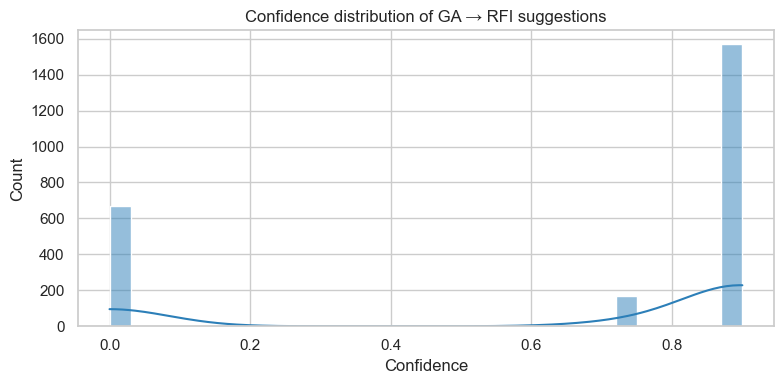

C:\Users\Andre\AppData\Local\Temp\ipykernel_40204\3333447031.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_rfi.values, y=top_rfi.index, palette='viridis')


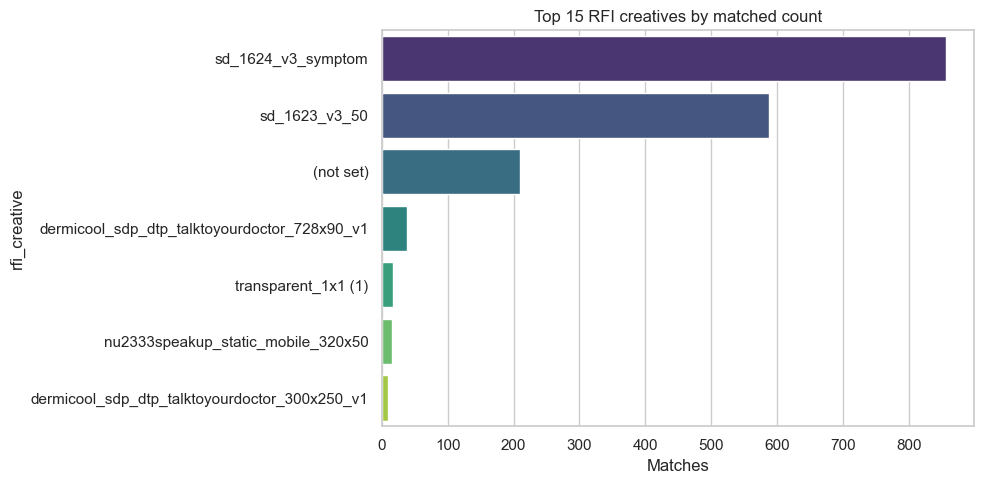

C:\Users\Andre\AppData\Local\Temp\ipykernel_40204\3333447031.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_ga_tokens.values, y=top_ga_tokens.index, palette='magma')


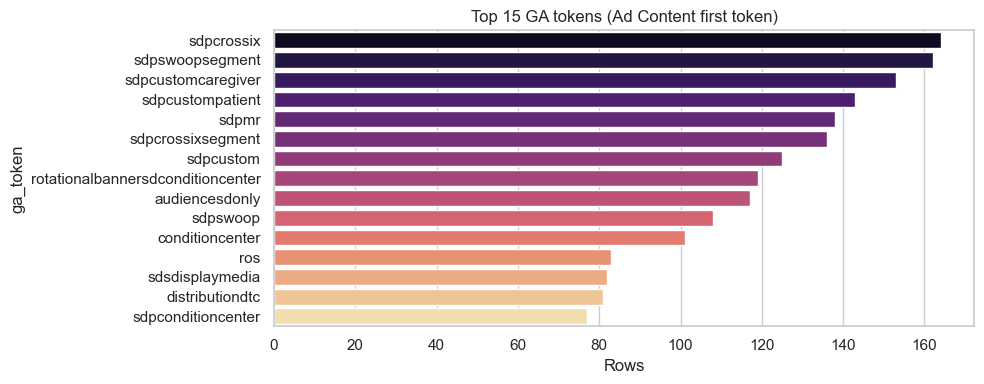

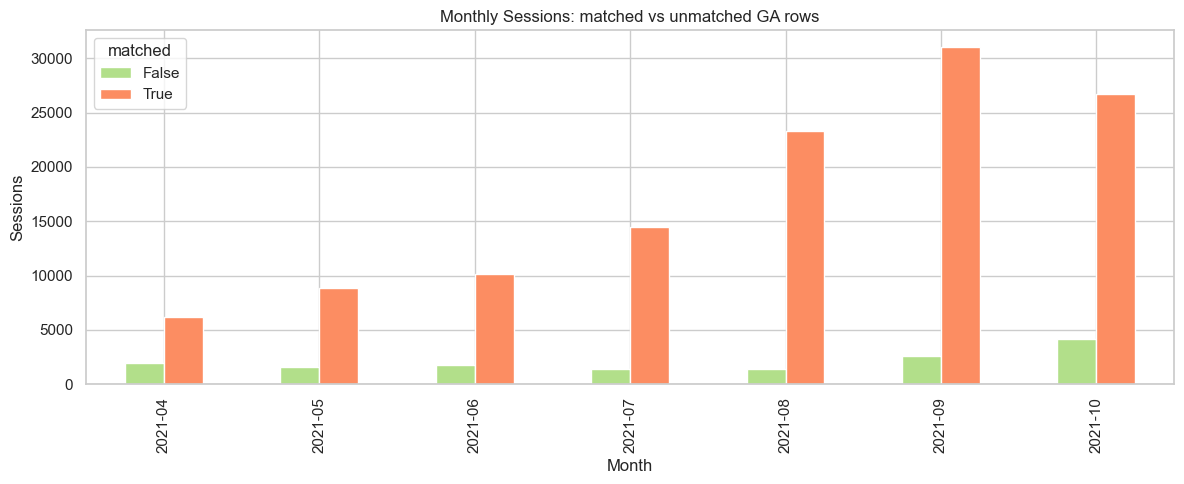

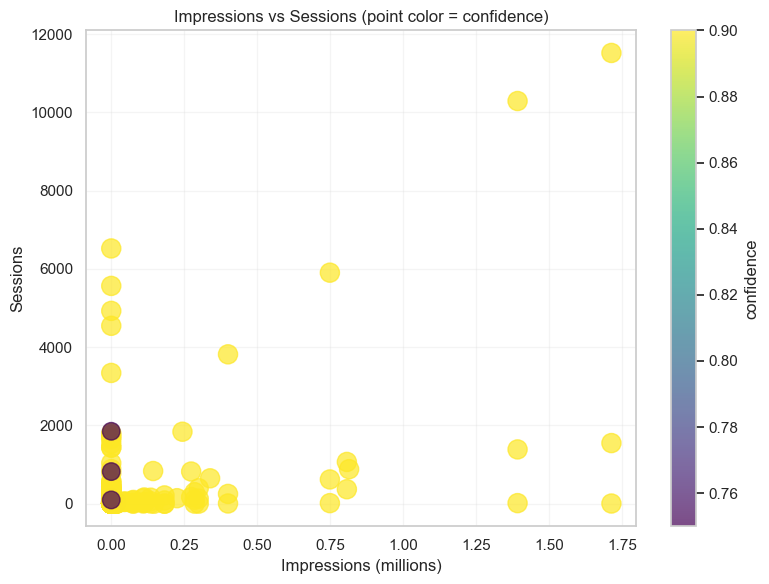


Impressions → Sessions ratio (matched rows):


count      1735.000
mean        794.032
std       10047.297
min           0.000
25%           0.440
50%           2.875
75%          14.000
max      285698.167
Name: imp_to_sess, dtype: float64

Width pivot empty or all zeros — skipping heatmap.

Sample of medium / low-confidence suggestions (for manual review):


,ga_index,Ad Content,ga_token,ga_num,ga_width,month,rfi_index,rfi_placement,rfi_creative,rfi_num,rfi_width,confidence


C:\Users\Andre\AppData\Local\Temp\ipykernel_40204\3333447031.py:168: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='conf_bin', y='Sessions', data=matches, palette='Set2')


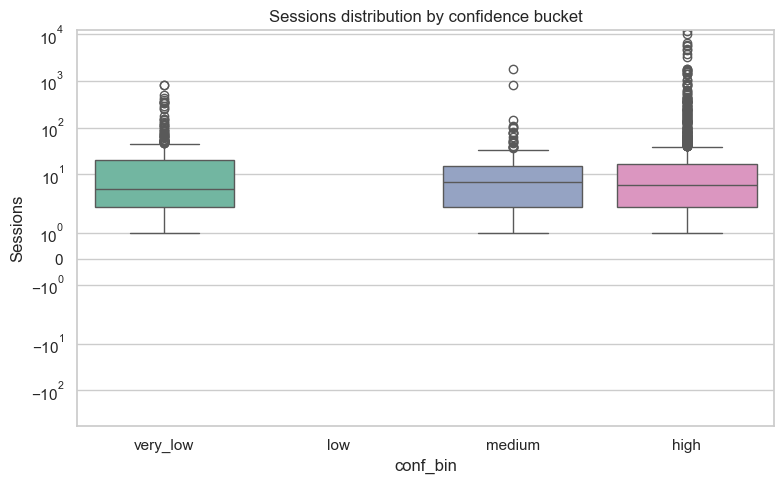

Saved ambiguous matches to 'ambiguous_match_suggestions.csv' for manual review.

EDA completed — review charts and the 'ambiguous_match_suggestions.csv' file (if created) for manual validation.


In [24]:
# ...existing code...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

sns.set(style="whitegrid", context="notebook", rc={"figure.figsize": (10,5)})

def has_nonzero(series):
    if series is None:
        return False
    try:
        s = pd.Series(series).dropna()
        if s.empty:
            return False
        # numeric check: at least one finite
        if np.issubdtype(s.dtype, np.number):
            return np.isfinite(s).any()
        return True
    except Exception:
        return False

# Safety: try to load from variables, fallback to CSVs saved by ETL
try:
    matches = matches_df.copy()
    ga_mat = ga_with_match.copy()
except NameError:
    matches = pd.read_csv("site_creative_match_suggestions_v2.csv")
    ga_mat = pd.read_csv("consolidated_ga_rfi_join_v2.csv")

# Basic coverage metrics (guarded)
if matches is None or len(matches) == 0:
    print("No matches dataframe available or it's empty — aborting EDA cell.")
else:
    total_ga = matches.get('ga_index')
    total_ga = total_ga.nunique() if total_ga is not None else 0
    matched_count = int(matches['rfi_index'].notna().sum()) if 'rfi_index' in matches.columns else 0
    matched_pct = matched_count / len(matches) * 100 if len(matches)>0 else 0
    conf_stats = matches['confidence'].describe() if 'confidence' in matches.columns else pd.Series(dtype=float)

    print(f"Total GA rows processed: {len(matches)}")
    print(f"Unique GA indices: {total_ga}")
    print(f"Matched rows: {matched_count} ({matched_pct:.1f}%)")
    print("\nConfidence summary:")
    if 'confidence' in matches.columns and has_nonzero(matches['confidence']):
        print(conf_stats.round(3))
    else:
        print("No confidence values present.")

    # Confidence distribution
    if 'confidence' in matches.columns and has_nonzero(matches['confidence']):
        plt.figure(figsize=(8,4))
        sns.histplot(matches['confidence'].dropna(), bins=30, kde=True, color='#2c7fb8')
        plt.title('Confidence distribution of GA → RFI suggestions')
        plt.xlabel('Confidence'); plt.tight_layout(); plt.show()
    else:
        print("Skipping confidence distribution plot: no confidence values.")

    # Top matched creatives (RFI) and GA tokens
    if {'rfi_placement','rfi_creative'}.intersection(matches.columns):
        top_rfi = matches.dropna(subset=['rfi_placement','rfi_creative']).groupby('rfi_creative').size().sort_values(ascending=False).head(15)
        if not top_rfi.empty:
            plt.figure(figsize=(10,5))
            sns.barplot(x=top_rfi.values, y=top_rfi.index, palette='viridis')
            plt.title('Top 15 RFI creatives by matched count'); plt.xlabel('Matches'); plt.tight_layout(); plt.show()
        else:
            print("No RFI creative matches to plot.")
    else:
        print("Columns rfi_placement/rfi_creative not found — skipping top creatives plot.")

    if 'ga_token' in matches.columns and has_nonzero(matches['ga_token'].value_counts()):
        top_ga_tokens = matches['ga_token'].value_counts().head(15)
        if not top_ga_tokens.empty:
            plt.figure(figsize=(10,4))
            sns.barplot(x=top_ga_tokens.values, y=top_ga_tokens.index, palette='magma')
            plt.title('Top 15 GA tokens (Ad Content first token)'); plt.xlabel('Rows'); plt.tight_layout(); plt.show()
        else:
            print("No GA tokens to plot.")
    else:
        print("Column ga_token not found or empty — skipping GA tokens plot.")

    # Month-level comparison: matched vs unmatched Sessions
    if 'Sessions' in ga_mat.columns:
        ga_mat = ga_mat.copy()
        ga_mat['matched'] = ga_mat['rfi_index'].notna() if 'rfi_index' in ga_mat.columns else False
        if 'month' not in ga_mat.columns and 'Month of Year' in ga_mat.columns:
            ga_mat['month'] = ga_mat['Month of Year']
        if 'month' in ga_mat.columns:
            monthly = ga_mat.groupby(['month','matched'])['Sessions'].sum().unstack(fill_value=0)
            if not monthly.empty:
                monthly = monthly.sort_index()
                monthly.plot(kind='bar', stacked=False, figsize=(12,5), color=['#b2df8a','#fc8d62'])
                plt.title('Monthly Sessions: matched vs unmatched GA rows')
                plt.ylabel('Sessions'); plt.xlabel('Month'); plt.tight_layout(); plt.show()
            else:
                print("Monthly aggregation empty — skipping monthly sessions plot.")
        else:
            print("No 'month' column in GA data — skipping monthly sessions plot.")
    else:
        print("No 'Sessions' column found in GA data — skipping monthly sessions plot.")

    # Impressions vs Sessions scatter (if impressions and sessions available)
    if 'Impressions' in ga_mat.columns and 'Sessions' in ga_mat.columns:
        df_scatter = ga_mat.copy()
        # ensure numeric columns
        if has_nonzero(df_scatter['Impressions']) and has_nonzero(df_scatter['Sessions']):
            df_scatter['confidence'] = df_scatter['confidence'].fillna(0) if 'confidence' in df_scatter.columns else 0
            df_scatter['Impressions_m'] = df_scatter['Impressions'] / 1e6
            valid_mask = df_scatter[['Impressions_m','Sessions']].notna().all(axis=1)
            if valid_mask.sum() > 0:
                plt.figure(figsize=(8,6))
                sc = plt.scatter(df_scatter.loc[valid_mask,'Impressions_m'], df_scatter.loc[valid_mask,'Sessions'],
                                 c=df_scatter.loc[valid_mask,'confidence'] if 'confidence' in df_scatter.columns else 'C0',
                                 cmap='viridis', s=(df_scatter.loc[valid_mask,'confidence']+0.05)*200 if 'confidence' in df_scatter.columns else 60,
                                 alpha=0.7)
                if 'confidence' in df_scatter.columns:
                    plt.colorbar(sc, label='confidence')
                plt.xlabel('Impressions (millions)'); plt.ylabel('Sessions')
                plt.title('Impressions vs Sessions (point color = confidence)')
                plt.grid(alpha=0.2); plt.tight_layout(); plt.show()

                # Impressions-to-sessions ratio for matched records
                matched_rows = df_scatter[df_scatter['rfi_index'].notna()].copy() if 'rfi_index' in df_scatter.columns else df_scatter.copy()
                if has_nonzero(matched_rows['Impressions']) and has_nonzero(matched_rows['Sessions']):
                    matched_rows['imp_to_sess'] = matched_rows.apply(lambda r: (r['Impressions'] / r['Sessions']) if r['Sessions']>0 else np.nan, axis=1)
                    print("\nImpressions → Sessions ratio (matched rows):")
                    display(matched_rows['imp_to_sess'].describe().round(3))
                else:
                    print("No valid matched Impressions/Sessions pairs to compute imp_to_sess.")
            else:
                print("No valid Impressions/Sessions pairs for scatter — skipping.")
        else:
            print("Impressions or Sessions column present but contains no numeric data — skipping scatter.")
    else:
        print("Impressions or Sessions column missing — skipping Impressions vs Sessions analysis.")

    # Width vs Width heatmap (showing match volume by GA width vs RFI width)
    if 'ga_width' in matches.columns and 'rfi_width' in matches.columns:
        pivot_w = matches.pivot_table(index='rfi_width', columns='ga_width', values='ga_index', aggfunc='count', fill_value=0)
        if pivot_w.size > 0 and pivot_w.sum().sum() > 0:
            plt.figure(figsize=(8,5))
            sns.heatmap(pivot_w, annot=True, fmt='d', cmap='Blues')
            plt.title('Count of matches by rfi_width (rows) vs ga_width (cols)')
            plt.xlabel('ga_width'); plt.ylabel('rfi_width'); plt.tight_layout(); plt.show()
        else:
            print("Width pivot empty or all zeros — skipping heatmap.")
    else:
        print("ga_width/rfi_width columns missing — skipping width heatmap.")

    # Examine low / medium confidence suggestions for manual review
    if 'confidence' in matches.columns:
        low_conf = matches[(matches['confidence'] < 0.75) & (matches['confidence'] > 0.0)].sort_values('confidence')
        print("\nSample of medium / low-confidence suggestions (for manual review):")
        display(low_conf.head(40))
    else:
        print("No confidence column — cannot show low/medium confidence suggestions.")

    # Confidence buckets and boxplot of Sessions (if Sessions exists)
    if 'confidence' in matches.columns:
        matches = matches.copy()
        matches['conf_bin'] = pd.cut(matches['confidence'].fillna(-0.01), bins=[-0.01,0.2,0.5,0.75,1.0], labels=['very_low','low','medium','high'])
        if 'ga_index' in matches.columns and 'ga_index' in ga_mat.columns and 'Sessions' in ga_mat.columns:
            sess_map = ga_mat.set_index('ga_index')['Sessions']
            matches['Sessions'] = matches['ga_index'].map(sess_map)
            if has_nonzero(matches['Sessions']):
                plt.figure(figsize=(8,5))
                sns.boxplot(x='conf_bin', y='Sessions', data=matches, palette='Set2')
                plt.title('Sessions distribution by confidence bucket'); plt.yscale('symlog'); plt.tight_layout(); plt.show()
            else:
                print("No Sessions values to plot in boxplot.")
        else:
            print("Cannot build Sessions boxplot: required columns missing.")
    else:
        print("No confidence column — skipping confidence bucket boxplot.")

    # Save a compact validation CSV of ambiguous matches
    if 'confidence' in matches.columns:
        ambig = matches[matches['confidence'].between(0.2,0.75)].copy()
        if not ambig.empty:
            ambig.to_csv('ambiguous_match_suggestions.csv', index=False)
            print("Saved ambiguous matches to 'ambiguous_match_suggestions.csv' for manual review.")
        else:
            print("No ambiguous matches to save.")
    else:
        print("No confidence column — skipping ambiguous CSV save.")

    print("\nEDA completed — review charts and the 'ambiguous_match_suggestions.csv' file (if created) for manual validation.")
# ...existing code...

In [470]:
rfi_monthly = rfi_df.groupby('Month')[['Impressions', 'Clicks']].sum()
ga_monthly = ga_df.groupby('Month of Year')[['Sessions', 'Users']].sum()

In [471]:
rfi_monthly['CTR'] = rfi_monthly['Clicks'] / rfi_monthly['Impressions']

In [472]:
rfi_monthly.head(10)

,Impressions,Clicks,CTR
Month,,,
2021-01,7598687,25283,0.003327
2021-02,7213436,19318,0.002678
2021-03,7358496,17712,0.002407
2021-04,7367985,21035,0.002855
2021-05,11096962,28409,0.002560
2021-06,15025723,28935,0.001926
2021-07,9109950,28240,0.003100
2021-08,11511409,32484,0.002822
2021-09,19799018,46001,0.002323


In [473]:
ga_monthly['Engagement Rate'] = ga_monthly['Sessions'] / ga_monthly['Users']

In [474]:
ga_monthly.head(7)

,Sessions,Users,Engagement Rate
Month of Year,,,
2021-04,8139,7536,1.080016
2021-05,10507,9445,1.112440
2021-06,11996,10461,1.146735
2021-07,15852,12777,1.240667
2021-08,24721,19410,1.273622
2021-09,33646,26479,1.270667
2021-10,30904,24981,1.237100


### 📊 Monthly Marketing Performance Analysis

After aggregating both **RFI** (paid media) and **GA** (on-site analytics) datasets by month, we can observe a comprehensive overview of the campaign’s performance over time.

---

#### 🖥️ RFI Data — Ad Visibility and Interaction

**Observations:**
- **Impressions** grew consistently from January to September, indicating an increase in campaign reach or budget allocation.  
- **Clicks** followed a similar upward trend, but the **CTR** gradually declined from ~0.33% in January to ~0.23% in September.  
- This decline in CTR may suggest **ad fatigue**, **less engaging creatives**, or a **broader audience reach** with lower relevance.  
- A brief recovery in October (0.28%) could be linked to refreshed ad content or optimized targeting.

---

#### 🌐 GA Data — Website Engagement

**Observations:**
- Both **sessions** and **unique users** increased month over month, with a clear peak in **September 2021**.  
- The **engagement rate** (Sessions/Users) remained above 1 throughout, suggesting that users interacted with the site more than once on average.  
- Engagement peaked between **August and September (≈1.27)**, coinciding with the months of highest ad exposure from RFI.

---

#### 📈 Combined Insights

- Both datasets show **parallel upward trends** in mid to late 2021, suggesting that increased advertising activity likely contributed to higher web engagement.  
- Despite the growth in visibility, **CTR decreased**, which could mean that while more users were exposed to the ads, their responsiveness diminished.  
- **Engagement Rate**, on the other hand, increased — implying that once users reached the site, they were more active or better qualified.  
- This combination may reflect a **trade-off between reach and quality**: broader campaigns drive awareness, while engagement quality depends on message targeting and ad relevance.

---

#### 🔍 Next Steps for Deeper Analysis

- Compare **CTR vs. Engagement Rate** month by month to identify alignment or divergence in performance.  
- Evaluate **creative types or channels** (if available) to understand which contributed most to engagement peaks.  
- Investigate whether campaign optimizations in October (e.g., new creatives or targeting changes) explain the partial CTR recovery.  
- Consider integrating **cost data** in future analyses to estimate **Return on Ad Spend (ROAS)** or **Cost per Click (CPC)** efficiency.


In [475]:
rfi_monthly = rfi_monthly.copy()
ga_monthly  = ga_monthly.copy()

if hasattr(rfi_monthly.index, "to_timestamp"):
    rfi_monthly.index = rfi_monthly.index.to_timestamp()
if hasattr(ga_monthly.index, "to_timestamp"):
    ga_monthly.index = ga_monthly.index.to_timestamp()

# Join on the timestamp index (inner join to keep only months present in both)
comparison_df = rfi_monthly.join(ga_monthly, how='inner', lsuffix='_rfi', rsuffix='_ga')

print("comparison_df columns:", comparison_df.columns.tolist())
display(comparison_df.head())

comparison_df columns: ['Impressions', 'Clicks', 'CTR', 'Sessions', 'Users', 'Engagement Rate']


,Impressions,Clicks,CTR,Sessions,Users,Engagement Rate
2021-04-01,7367985,21035,0.002855,8139,7536,1.080016
2021-05-01,11096962,28409,0.002560,10507,9445,1.112440
2021-06-01,15025723,28935,0.001926,11996,10461,1.146735
2021-07-01,9109950,28240,0.003100,15852,12777,1.240667
2021-08-01,11511409,32484,0.002822,24721,19410,1.273622


C:\Users\Andre\AppData\Local\Temp\ipykernel_33412\356407765.py:40: UserWarning: Glyph 128226 (\N{PUBLIC ADDRESS LOUDSPEAKER}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
C:\Users\Andre\AppData\Local\Temp\ipykernel_33412\356407765.py:40: UserWarning: Glyph 128433 (\N{THREE BUTTON MOUSE}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
C:\Users\Andre\AppData\Local\Temp\ipykernel_33412\356407765.py:40: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
C:\Users\Andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128226 (\N{PUBLIC ADDRESS LOUDSPEAKER}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site

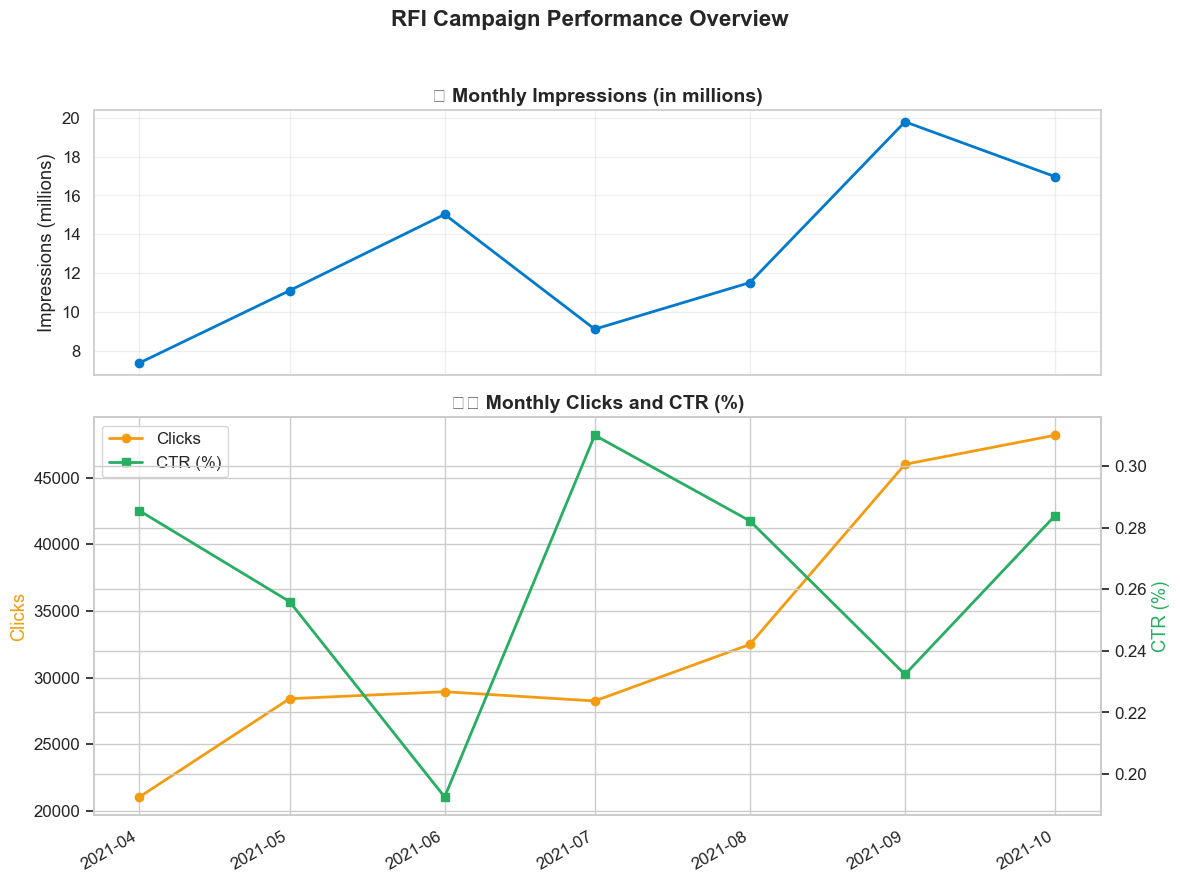

In [476]:
from matplotlib.dates import DateFormatter
date_fmt = DateFormatter('%Y-%m')

sns.set(style="whitegrid", font_scale=1.1)
fig, axes = plt.subplots(2, 1, figsize=(12, 9),
                         gridspec_kw={'height_ratios': [1, 1.5]},
                         sharex=True)

# Top: Impressions in millions
axes[0].plot(comparison_df.index, comparison_df['Impressions']/1e6,
             color='#007acc', marker='o', linewidth=2)
axes[0].set_title('📢 Monthly Impressions (in millions)', fontsize=14, weight='bold')
axes[0].set_ylabel('Impressions (millions)')
axes[0].grid(alpha=0.3)

# Bottom: Clicks and CTR
ax_main = axes[1]
ax2 = ax_main.twinx()

ax_main.plot(comparison_df.index, comparison_df['Clicks'],
             color='#f39c12', marker='o', linewidth=2, label='Clicks')
ax2.plot(comparison_df.index, comparison_df['CTR']*100,
         color='#27ae60', marker='s', linewidth=2, label='CTR (%)')

ax_main.set_ylabel('Clicks', color='#f39c12')
ax2.set_ylabel('CTR (%)', color='#27ae60')
ax_main.set_title('🖱️ Monthly Clicks and CTR (%)', fontsize=14, weight='bold')

# Legends
lines, labels = ax_main.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax_main.legend(lines + lines2, labels + labels2, loc='upper left')

# Format x-axis as YYYY-MM
axes[1].xaxis.set_major_formatter(date_fmt)
fig.autofmt_xdate()  # rotate labels nicely

plt.suptitle('RFI Campaign Performance Overview', fontsize=16, weight='bold')
plt.xlabel('Month')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

C:\Users\Andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


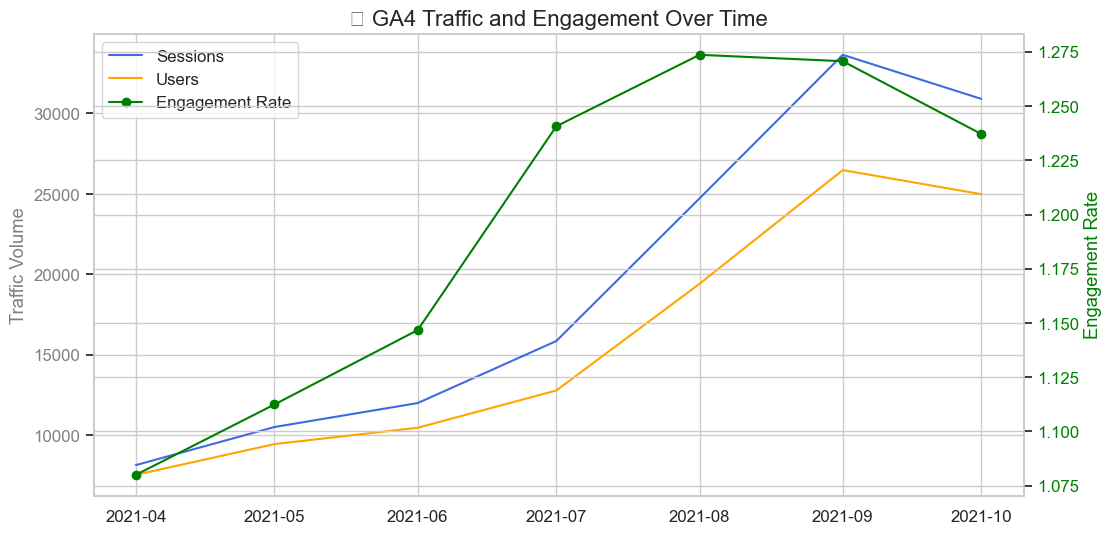

In [477]:
# --- 2. GA Trend: Sessions, Users & Engagement Rate ---
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(ga_monthly.index, ga_monthly['Sessions'], color='royalblue', label='Sessions')
ax1.plot(ga_monthly.index, ga_monthly['Users'], color='orange', label='Users')
ax1.set_ylabel('Traffic Volume', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')
ax1.set_title('🌐 GA4 Traffic and Engagement Over Time', fontsize=16)

# Secondary axis for Engagement Rate
ax2 = ax1.twinx()
ax2.plot(ga_monthly.index, ga_monthly['Engagement Rate'], color='green', marker='o', label='Engagement Rate')
ax2.set_ylabel('Engagement Rate', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', frameon=True)

plt.show()


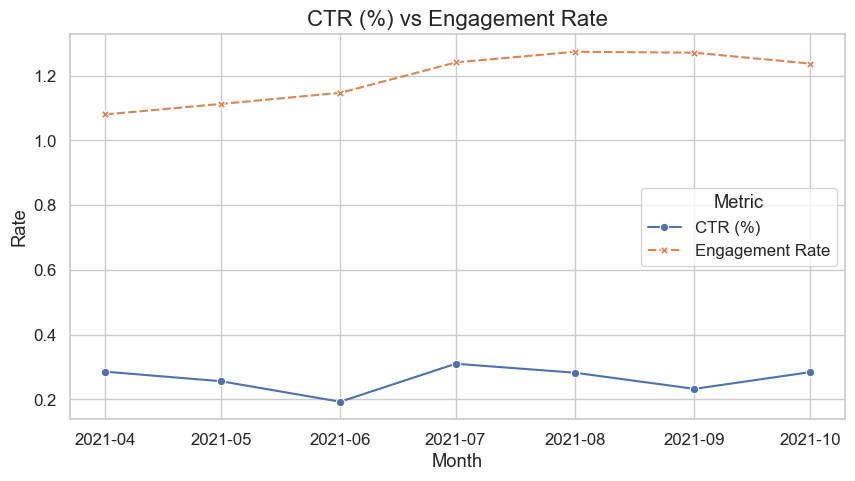

In [478]:
comparison_df_plot = comparison_df.copy()
comparison_df_plot['CTR (%)'] = comparison_df_plot['CTR'] * 100

plt.figure(figsize=(10,5))
sns.lineplot(data=comparison_df_plot[['CTR (%)', 'Engagement Rate']], markers=True)
plt.title('CTR (%) vs Engagement Rate', fontsize=16)
plt.ylabel('Rate')
plt.xlabel('Month')
plt.legend(title='Metric')
plt.show()


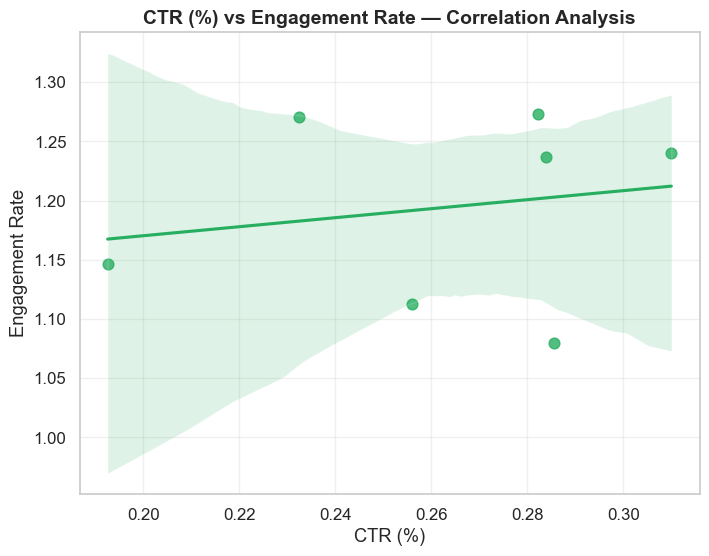

In [479]:
# Option 1: align on the intersection of months and drop missing values
common_idx = rfi_monthly.index.intersection(ga_monthly.index)
x = (rfi_monthly.loc[common_idx, 'CTR'] * 100).astype(float)   # CTR in percent
y = ga_monthly.loc[common_idx, 'Engagement Rate'].astype(float)
# Drop possible NaNs
mask = x.notna() & y.notna()
x = x[mask]
y = y[mask]

plt.figure(figsize=(8,6))
sns.regplot(x=x.values, y=y.values, color='#27ae60', scatter_kws={'s':60})
plt.title('CTR (%) vs Engagement Rate — Correlation Analysis', fontsize=14, weight='bold')
plt.xlabel('CTR (%)')
plt.ylabel('Engagement Rate')
plt.grid(alpha=0.3)
plt.show()

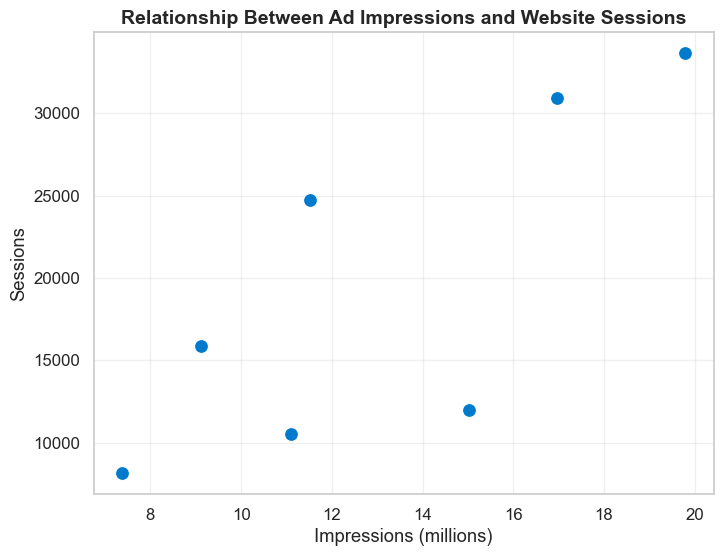

In [480]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=rfi_monthly['Impressions']/1e6, y=ga_monthly['Sessions'], 
                color='#007acc', s=100)
plt.title('Relationship Between Ad Impressions and Website Sessions', fontsize=14, weight='bold')
plt.xlabel('Impressions (millions)')
plt.ylabel('Sessions')
plt.grid(alpha=0.3)
plt.show()


C:\Users\Andre\AppData\Local\Temp\ipykernel_33412\3178818351.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=stages, y=percent, palette='crest')


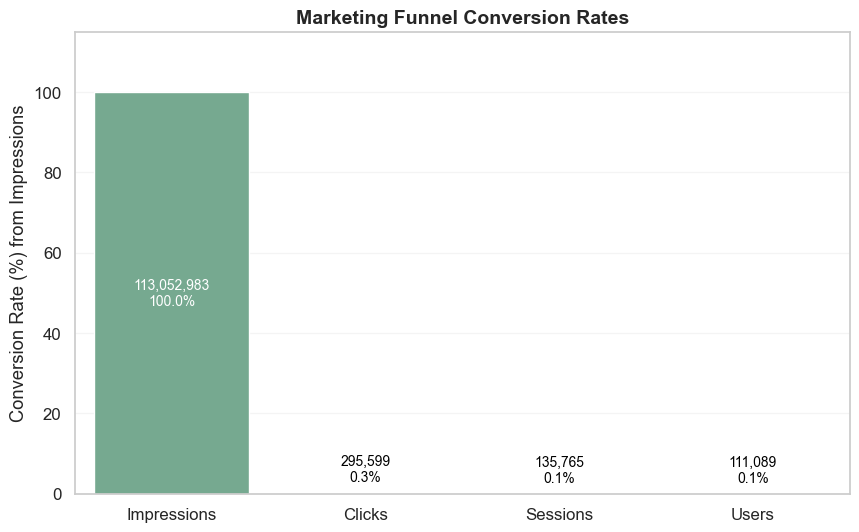

In [481]:
# Variant B: labels inside bars (white text) - useful if bars are tall
plt.figure(figsize=(10,6))
ax = sns.barplot(x=stages, y=percent, palette='crest')

for patch, total, pct in zip(ax.patches, values, percent):
    height = patch.get_height()
    # Place label vertically centered inside bar; if bar too short, move it above
    if height >= max(percent) * 0.08:
        y_text = height / 2.
        va = 'center'
        color = 'white'
    else:
        y_text = height + max(percent) * 0.02
        va = 'bottom'
        color = 'black'
    label = f"{total:,.0f}\n{pct:.1f}%"
    ax.text(patch.get_x() + patch.get_width() / 2., y_text, label,
            ha='center', va=va, fontsize=10, color=color)

plt.title('Marketing Funnel Conversion Rates', fontsize=14, weight='bold')
plt.ylabel('Conversion Rate (%) from Impressions')
plt.ylim(0, max(percent) * 1.15)
plt.grid(alpha=0.2, axis='y')
plt.show()

<Figure size 1000x600 with 0 Axes>

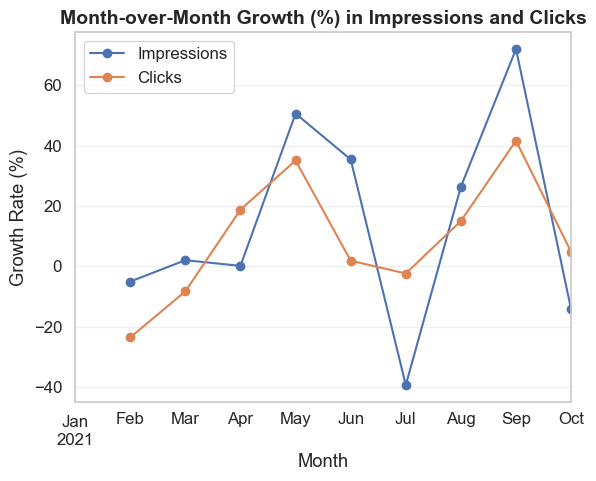

In [482]:
growth = rfi_monthly.pct_change()*100
plt.figure(figsize=(10,6))
growth[['Impressions','Clicks']].plot(marker='o')
plt.title('Month-over-Month Growth (%) in Impressions and Clicks', fontsize=14, weight='bold')
plt.ylabel('Growth Rate (%)')
plt.grid(alpha=0.3)
plt.show()


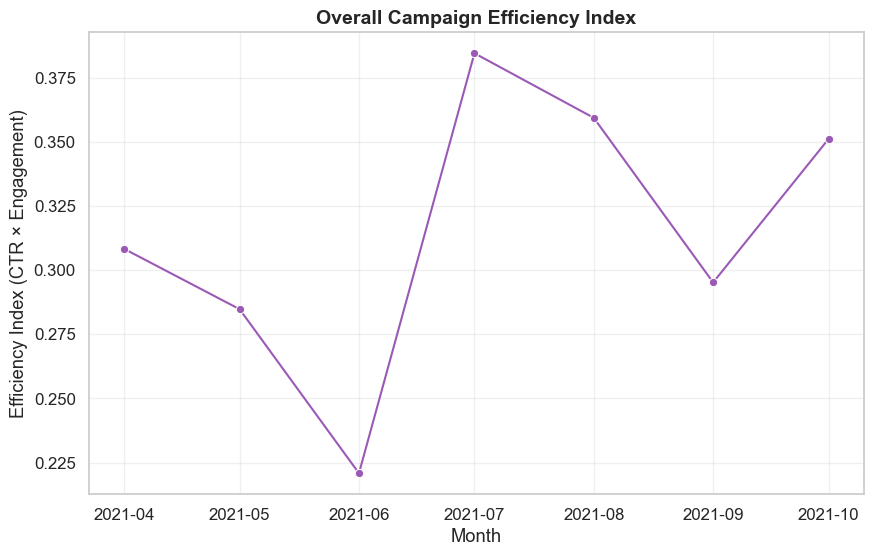

In [483]:
efficiency = (rfi_monthly['CTR'] * ga_monthly['Engagement Rate']) * 100
efficiency_df = pd.DataFrame({'Month': rfi_monthly.index, 'Efficiency Index': efficiency})

plt.figure(figsize=(10,6))
sns.lineplot(x='Month', y='Efficiency Index', data=efficiency_df, 
             marker='o', color='#9b59b6')
plt.title('Overall Campaign Efficiency Index', fontsize=14, weight='bold')
plt.xlabel('Month')
plt.ylabel('Efficiency Index (CTR × Engagement)')
plt.grid(alpha=0.3)
plt.show()


In [484]:
rfi_monthly['Impressions'].sum()


np.int64(113052983)

In [485]:
rfi_monthly['Clicks'].sum()

np.int64(295599)

In [486]:
(rfi_monthly['CTR'].mean() * 100).round(2)

np.float64(0.27)

In [487]:
rfi_monthly['CTR'].idxmax()

Timestamp('2021-01-01 00:00:00')

In [488]:
rfi_monthly['Impressions'].idxmax()

Timestamp('2021-09-01 00:00:00')

In [489]:
rfi_monthly['Clicks'].idxmax()

Timestamp('2021-10-01 00:00:00')

In [490]:
ga_monthly['Sessions'].sum()

np.int64(135765)

In [491]:
ga_monthly['Users'].sum()

np.int64(111089)

In [492]:
ga_monthly['Engagement Rate'].mean().round(2)

np.float64(1.19)

In [493]:
ga_monthly['Sessions'].idxmax()

Timestamp('2021-09-01 00:00:00')

In [494]:
ga_monthly['Engagement Rate'].idxmax()

Timestamp('2021-08-01 00:00:00')

In [495]:
(ga_monthly['Sessions'] / rfi_monthly['Clicks']).mean().round(2)


np.float64(0.55)

In [496]:
(ga_monthly['Users'] / ga_monthly['Sessions']).mean().round(2)


np.float64(0.84)

In [497]:
((rfi_monthly['CTR'] * ga_monthly['Engagement Rate']) * 100).mean().round(2)


np.float64(0.31)

### 📈 Marketing Performance Analysis — RFI & GA Overview

This analysis summarizes the performance of the **Dermicool FY21 digital campaign**, combining data from the **RFI dataset** (paid media performance) and **GA4** (on-site engagement metrics).

---

#### 🧩 RFI Campaign Overview (Paid Media)

Across the campaign period, the ads generated a total of **113 million impressions** and **295.6K clicks**, resulting in an **average Click-Through Rate (CTR)** of **0.27%**.

- The campaign reached its **highest visibility** in **September 2021**, with nearly 20 million impressions.
- The **highest engagement** in terms of clicks occurred in **October 2021**, indicating a delayed response following the exposure peak.
- Interestingly, **January 2021** recorded the **highest CTR**, suggesting stronger ad relevance and creative effectiveness early in the campaign.

These results reflect a typical pattern of **initial audience novelty**, followed by a plateau in engagement efficiency as frequency and ad fatigue increase.

---

#### 🌐 GA4 Web Analytics Overview (User Interaction)

During the same period (April–October 2021), the site registered a total of **135,765 sessions** and **111,089 users**, with an **average Engagement Rate (ER)** of **1.19**.

- The **peak of sessions** occurred in **September 2021**, aligning with the RFI exposure maximum.
- The **highest Engagement Rate** was reached in **August 2021**, one month before the traffic peak, implying effective audience pre-engagement and possible retargeting momentum.
- The ratio of **Users/Sessions = 0.84**, meaning most visits came from unique users, with low repeat frequency — common in awareness-oriented campaigns.

---

#### 🔄 Cross-Dataset Insights

By comparing both data sources, the **average ratio of Sessions per Click is 0.55**, meaning roughly **1 website session for every 2 paid clicks**.  
This suggests that not every ad click translated into a GA-tracked visit, which may stem from:
- Redirect latency or tracking loss (cookie restrictions, mobile app routing)
- User drop-off before full page load
- Attribution discrepancies between platforms

Moreover, the **Efficiency Index (CTR × ER)** averaged **0.31**, showing that the campaign maintained a relatively balanced performance between ad engagement and site interaction quality.

---

#### 💡 Key Takeaways

- **High reach but moderate efficiency:** Despite strong impression volumes, CTR remained under 0.3%, signaling potential for creative optimization.
- **Good conversion alignment:** Peaks in ad exposure and site sessions match temporally, validating campaign consistency.
- **Engagement focus needed:** Increasing ER or CTR could yield stronger ROI, especially by refining audience segmentation and refreshing creative materials over time.
- **Tracking enhancement recommended:** Improving cross-platform attribution could help measure true post-click engagement more precisely.

---

✅ *Next Steps:*  
- Perform correlation analysis between RFI CTR and GA Engagement Rate to validate behavioral linkage.  
- Investigate device-level or placement-level performance for deeper optimization opportunities.  
- Explore time-lag effects (ad click → session) using timestamp matching if available.


C:\Users\Andre\AppData\Local\Temp\ipykernel_33412\1080865320.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='CTR', y=top10.index, data=top10, palette='viridis')


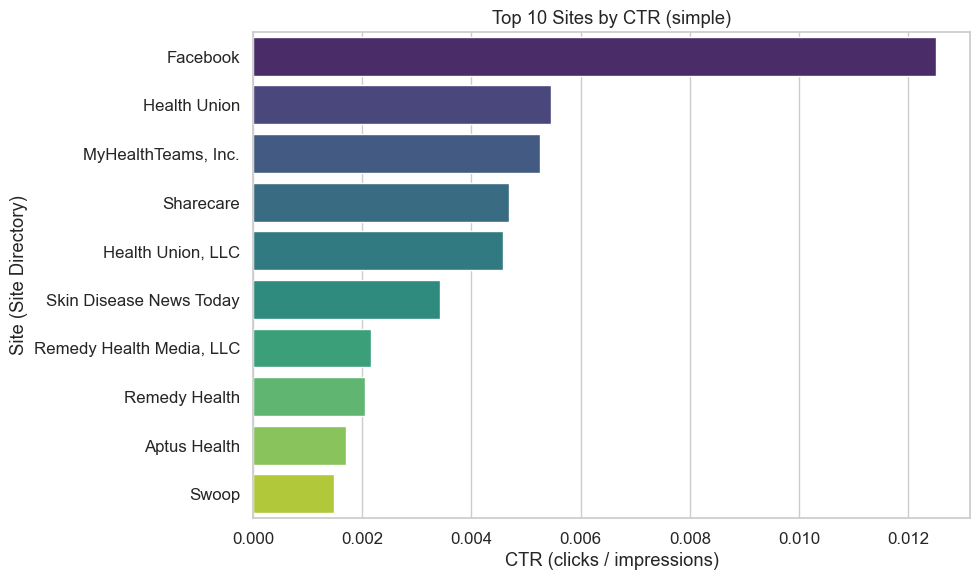

In [498]:

# Aggregate
site_perf = rfi_df.groupby('Site (Site Directory)')[['Impressions', 'Clicks']].sum()

# Safe CTR (avoid division by zero)
site_perf['CTR'] = site_perf['Clicks'] / site_perf['Impressions']
site_perf['CTR'] = site_perf['CTR'].replace([np.inf, -np.inf], np.nan).fillna(0.0)


# Plot top 10 by CTR
top10 = site_perf.sort_values('CTR', ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x='CTR', y=top10.index, data=top10, palette='viridis')
plt.xlabel('CTR (clicks / impressions)')
plt.title('Top 10 Sites by CTR (simple)')
plt.tight_layout()
plt.show()

C:\Users\Andre\AppData\Local\Temp\ipykernel_33412\2086099913.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=creative_perf, x='CTR', y=creative_perf.index, palette='coolwarm')


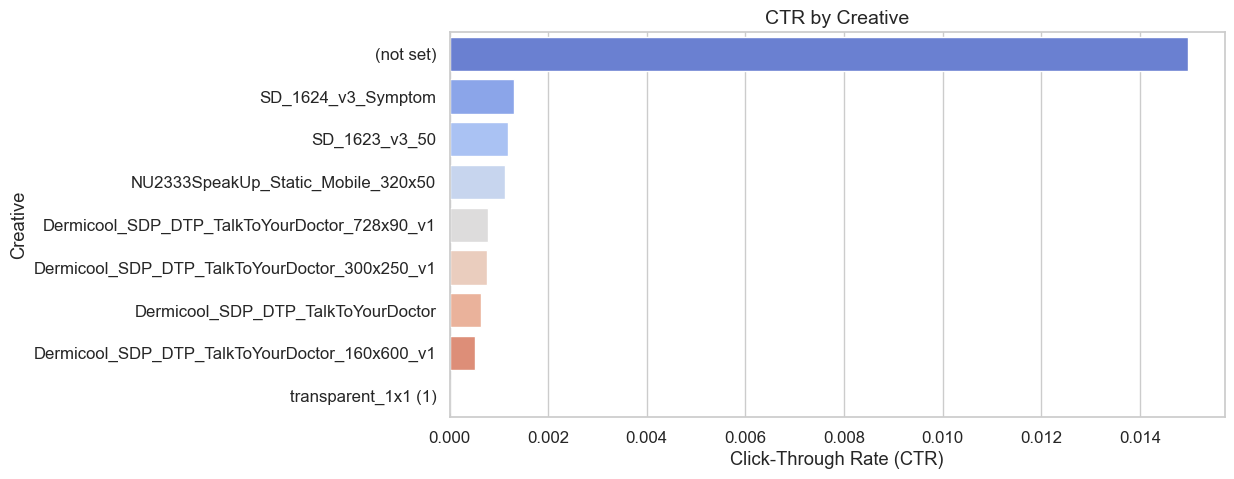

In [499]:
creative_perf = (
    rfi_df.groupby('Creative')[['Impressions', 'Clicks']]
    .sum()
    .assign(CTR=lambda x: x['Clicks'] / x['Impressions'])
    .sort_values('CTR', ascending=False)
)

plt.figure(figsize=(10, 5))
sns.barplot(data=creative_perf, x='CTR', y=creative_perf.index, palette='coolwarm')
plt.title('CTR by Creative', fontsize=14)
plt.xlabel('Click-Through Rate (CTR)')
plt.ylabel('Creative')
plt.show()


C:\Users\Andre\AppData\Local\Temp\ipykernel_33412\2601366415.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=size_perf, x='CTR', y=size_perf.index, palette='mako')


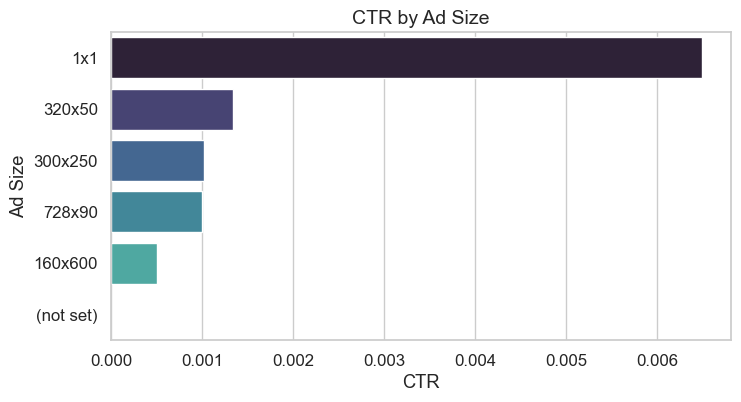

In [500]:
size_perf = (
    rfi_df.groupby('Creative Dimensions')[['Impressions', 'Clicks']]
    .sum()
    .assign(CTR=lambda x: x['Clicks'] / x['Impressions'])
    .sort_values('CTR', ascending=False)
)

plt.figure(figsize=(8, 4))
sns.barplot(data=size_perf, x='CTR', y=size_perf.index, palette='mako')
plt.title('CTR by Ad Size', fontsize=14)
plt.xlabel('CTR')
plt.ylabel('Ad Size')
plt.show()


### 🎯 Ad Performance Breakdown

To understand what factors influenced user engagement, the campaign data was analyzed by **site**, **creative**, and **ad size**.

- **By Site:** Revealed which publishers generated higher CTRs or traffic efficiency.  
- **By Creative:** Showed which ad messages or designs resonated best with users.  
- **By Ad Size:** Helped identify which banner dimensions performed better in driving clicks.

This level of segmentation provides actionable insight for future media planning and creative optimization, ensuring that investment is concentrated on high-performing assets and placements.
